I used the chi2 scoring function, which computes chi-squared stats between each non-negative feature and the class.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
# Load the NSL-KDD dataset
train_data = pd.read_csv('Train_data.csv')

In [3]:
# Separate features (X) and target variable (y)
x = train_data.iloc[:, :-1] # Selects all rows and all columns except the last column
y = train_data.iloc[:, -1]  # Selects all rows and the last column, represents the target variable

In [4]:
print(y)

0         normal
1         normal
2        anomaly
3         normal
4         normal
          ...   
25187    anomaly
25188    anomaly
25189    anomaly
25190    anomaly
25191    anomaly
Name: class, Length: 25192, dtype: object


In [5]:
x.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
# Function to encode discrete features in a dataframe
def encodify(dataframe, feature):
    encoder = LabelEncoder()
    encoder.fit(dataframe[feature])                         # 'fit' method is called on the specified feature of the dataframe to fit the encoder to the unique values in that feature
    encoded_feature = encoder.transform(dataframe[feature]) # 'transform' method is called on the same feature to transform the original values into encoded numerical values
    dataframe[feature] = encoded_feature                    # The transformed values are assigned back to the same feature in the dataframe

In [7]:
discrete_feature_l = ['protocol_type', 'service', 'flag']   # Creates list containing the names of the discrete features that need to be encoded
for feature in discrete_feature_l:
    encodify(x, feature)                                    # Performs the encoding function for each discrete feature in the 'x' dataframe

# This is used to transform categorical or discrete features for machine learning models that require numerical inputs

In [8]:
train_data.head(5)
# x.head(5) cannot be implemented, because it changes form from a dataframe to an array after getting encoded

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [9]:
feature_set = train_data.columns[:-1] # Selects all columns names, excluding the last column, to assign to an Index object

In [10]:
# Perform feature scaling
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# The 'fit_transform' method calculates the mean and standard deviation of each feature in 'x'.
# It then scales and centers each feature by subtracting the mean and dividing by the standard deviation.
# This standardizes the features, making them have zero mean and unit variance.
# The scaled features are returned as a transformed array.

In [11]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# The 'train_test_split' method is used to split data into random train and test datasets.
# 'x' = input features, 'y' = target variable, 'test_size=0.2' means 20% of the dataset is the testing set
# 'random_state=42' sets the random seed so that the random splitting of the data is reproducible
# The 4 resulting subsets are assigned to variables

In [12]:
# Perform oversampling for class balancing
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

# 'SMOTE' is Synthetic Minority Oversampling Technique. It addresses any class imbalance problem in a dataset by generating synthetic samples for the minority class.
# This oversampling technique is applied to the training sets.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

In [13]:
# Perform feature selection using Chi Squared
# selector = SelectKBest(score_func=chi2, k = 10)  # Select top 10 features
# selector = SelectKBest(score_func=chi2, k = 15)  # Select top 15 features
selector = SelectKBest(score_func=chi2, k = 20)  # Select top 20 features
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)

In [14]:
selected_features = selector.get_support()
# top_10 = feature_set[selected_features][:10]
# top_15 = feature_set[selected_features][:15]
top_20 = feature_set[selected_features][:20]
print(top_20)

Index(['service', 'flag', 'wrong_fragment', 'logged_in', 'count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')


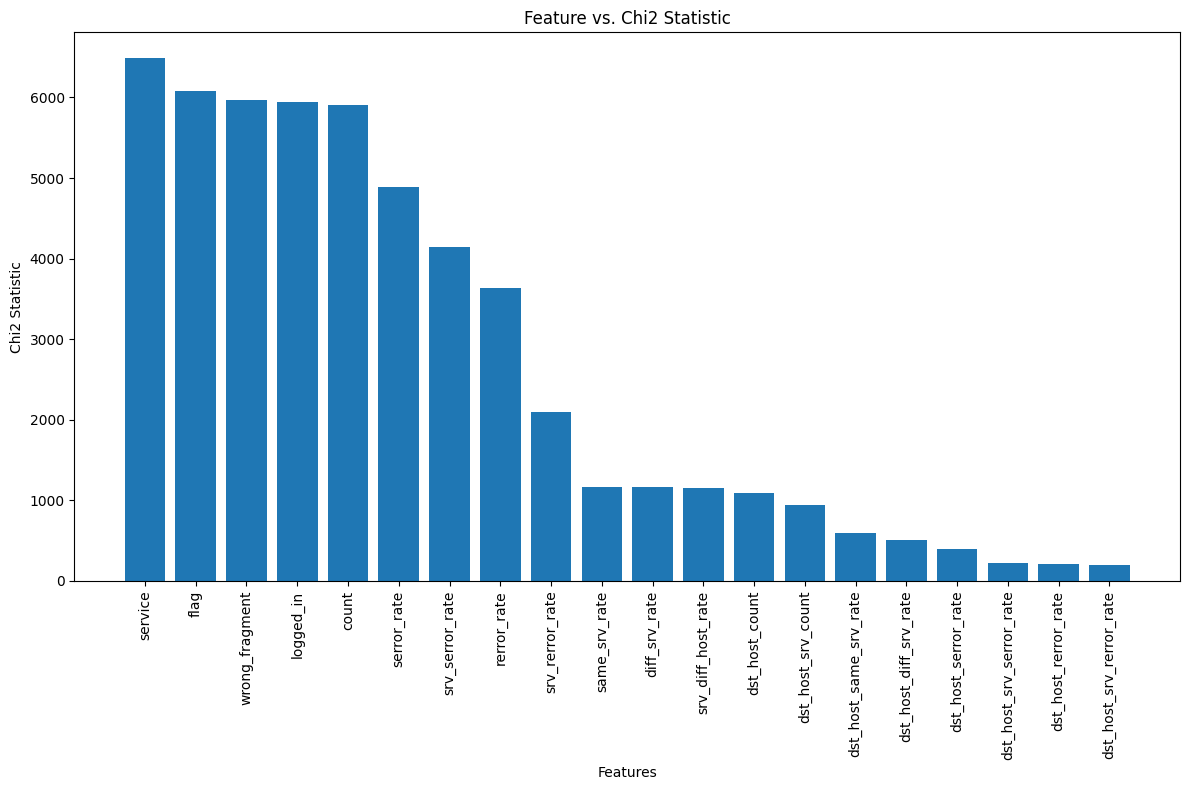

In [15]:
# Get the feature names
feature_names = top_20

# Get the feature scores from the selector and sort them in descending order
feature_scores = selector.scores_
sorted_indices = (-feature_scores).argsort()
sorted_feature_scores = feature_scores[sorted_indices][:20]

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(feature_names, sorted_feature_scores)
plt.xlabel('Features')
plt.ylabel('Chi2 Statistic')
plt.title('Feature vs. Chi2 Statistic')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout spacing
plt.show()

In [16]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train_selected, y_train)

RandomForestClassifier()

In [17]:
# Evaluate the Random Forest classifier
rf_accuracy = rf_classifier.score(x_test_selected, y_test)

In [18]:
print(rf_accuracy)

0.9932526294899782


In [19]:
pred_test_y = rf_classifier.predict(x_test_selected)
print(pred_test_y)

['anomaly' 'normal' 'anomaly' ... 'normal' 'normal' 'normal']


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
accuracy_score(y_test, pred_test_y)

0.9932526294899782

In [21]:
confusion_matrix(y_test, pred_test_y)

array([[2343,   22],
       [  12, 2662]])

In [22]:
f1_score(y_test, pred_test_y, average='macro')

0.9932254794035216

In [23]:
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel = 'rbf')
svm_classifier.fit(x_train_selected, y_train)

SVC()

In [24]:
# Evaluate the SVM classifier
svm_accuracy = svm_classifier.score(x_test_selected, y_test)
print(svm_accuracy)

0.9660646953760667


In [25]:
# Initialize and train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_selected, y_train)

GaussianNB()

In [26]:
  # Evaluate the Naive Bayes classifier
nb_accuracy = nb_classifier.score(x_test_selected, y_test)
print(nb_accuracy)

0.9023615796785076
